<a href="https://colab.research.google.com/github/nayanapreethi/AICTE-Internships-2025-June-GHG-Emissions-Prediction/blob/main/GHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Available columns in dataset: ['Code', 'Name', 'Substance', 'Unit', 'Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins', 'Unnamed: 7', 'DQ ReliabilityScore of Factors without Margins', 'DQ TemporalCorrelation of Factors without Margins', 'DQ GeographicalCorrelation of Factors without Margins', 'DQ TechnologicalCorrelation of Factors without Margins', 'DQ DataCollection of Factors without Margins', 'Source', 'Year']
✅ R² Score: 0.9994
✅ RMSE: 0.0058


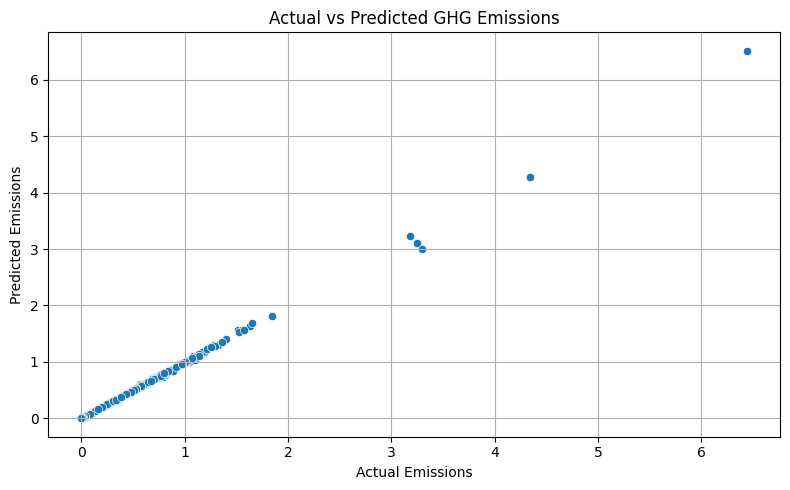

['models/rf_model.joblib']

In [6]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# 📂 Load the Excel File (upload to Colab before running)
excel_file = '/content/af60b10b8dad38110304.xlsx'
years = range(2010, 2017)

# 🔁 Read and Merge All Year Sheets (Commodity + Industry)
all_data = []

for year in years:
    try:
        df_com = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Commodity')
        df_ind = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Industry')

        df_com['Source'] = 'Commodity'
        df_ind['Source'] = 'Industry'
        df_com['Year'] = df_ind['Year'] = year

        df_com.columns = df_com.columns.str.strip()
        df_ind.columns = df_ind.columns.str.strip()

        df_com.rename(columns={'Commodity Code': 'Code', 'Commodity Name': 'Name'}, inplace=True)
        df_ind.rename(columns={'Industry Code': 'Code', 'Industry Name': 'Name'}, inplace=True)

        combined = pd.concat([df_com, df_ind], ignore_index=True)
        all_data.append(combined)

    except Exception as e:
        print(f"Error processing year {year}: {e}")

# 🧾 Combine all data
df = pd.concat(all_data, ignore_index=True)
print("Available columns in dataset:", df.columns.tolist())

# ✅ Set target and feature columns
target_column = 'Supply Chain Emission Factors with Margins'
feature_columns = [
    'Supply Chain Emission Factors without Margins',
    'Margins of Supply Chain Emission Factors',
    'DQ ReliabilityScore of Factors without Margins',
    'DQ TemporalCorrelation of Factors without Margins',
    'DQ GeographicalCorrelation of Factors without Margins',
    'DQ TechnologicalCorrelation of Factors without Margins',
    'DQ DataCollection of Factors without Margins',
    'Year'
]

# 🎯 Extract Features and Target
X = df[feature_columns]
y = df[target_column]

# ✅ Impute missing values with column means
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# 🧪 Train-Test Split
if len(X) == 0 or len(y) == 0:
    raise ValueError("X or y is empty. Check the input data after imputation.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚖️ Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🌲 Train Random Forest with GridSearchCV
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}

grid = GridSearchCV(model, param_grid, scoring='r2', cv=3)
grid.fit(X_train_scaled, y_train)

# ✅ Best Model
best_model = grid.best_estimator_

# 📈 Evaluate
y_pred = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ R² Score: {r2:.4f}")
print(f"✅ RMSE: {rmse:.4f}")

# 📊 Visualization
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Emissions")
plt.ylabel("Predicted Emissions")
plt.title("Actual vs Predicted GHG Emissions")
plt.grid(True)
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/actual_vs_predicted.png")
plt.show()

# 💾 Save the Trained Model
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/rf_model.joblib")
